# Analysing topics with hSBM

In order to explore the content of the collected Wikipedia pages, we deploy a  hierarchical stochastic block model (hSBM). The model is used to identify prevalent topics in a text corpora, and it relies on integration of  teqniques used for community detection in networks (Gerlach et al. 2018). HSBM has proven to perform better than the more widely used latent Dirichlet allocation (LDA). Topics can be identified by the HSBM by representing the text corpora as a bipartite network in which nodes are documents and words, and the weight of the edges connecting nodes are determined by word-occurrences in each document. The model automatically detects the relevant number of topics and makes a hierarchical clustering of nodes (ibid.).

We were only able to run the hSBM in Google Colab. The code is attached and it can also be found through the link below. Through the hSBM we identifyied e list of topics and corresponding probabilities for each document to belong to a certain topic. We stored this information in a dataframe to be able to further analyse it in this notebook.

https://colab.research.google.com/drive/10_H2VPqhq69gVBz0nWEyC8aqVadAq9lc?usp=sharing

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
import collections
import netwulf as nw
from IPython.display import Image

In [2]:
# We read the dataframes with data from HSBM 
topics=pd.read_csv('HSBM_topics_final.csv')
topics.drop('Unnamed: 0', axis = 'columns', inplace = True)
HSBM_probs=pd.read_csv('HSBM_probs_final.csv')
HSBM_probs.drop('Unnamed: 0', axis = 'columns', inplace = True)

**Plotting result of HSBM** <br>
We plot the word-document bipartite network generated thought hSBM. Document-nodes are on the left, and word-nodes are on the right. Colors correspond to the different groups. The nodes of words and documents are grouped on multiple levels.On the highest level (in the center of the graph) all nodes belong to the same group, on the second highest level the network is splot into word- and document-nodes. We are interested in the word-groups as these correspond to topics of the documents. The SBM has a hierarchical structure which implies that topics at the lowest levels (far to the right) contain more granular information about the content of the documents, whereas, topics at higher levels are clusters of the lower level topics and, thus, more aggregate (ref). 

The hSBM generates 397 topics at Level 0, 59 topics at Level 1, 11 topics at Level 2, 2 topics at Level 3, and 1 topic at Level 4. We choose to work with topics at level 1 which we deem to be the most appropriate level to examine as the topics appear to be reasonably coherent and manageable to manually select from. **A list of topics at all levels is attached in Appendix X.**

The documents on the left side are sorted such that the disciplines appear alphabethically such that anthropologists are the first nodes and the last are sociologists. The number of documents vary within each discipline, and thus we show the order in the table below. From the graph below we can sense how the document-nodes seem to cluster in what might correspond to disciplinary groupings. This is sespecially true for the cluster document nodes in the bottom which could indicate a sociology group.

In [237]:
# Showing the order and number of documents for each discipline as they appear in the graph below. 
pd.DataFrame(HSBM_probs.groupby(['discipline']).size())

0
discipline              
Anthropologist       149
Economist            825
Multiple              86
Political Scientist  233
Psychologist         299
Sociologist          513

                 Bipartite network of documents and words


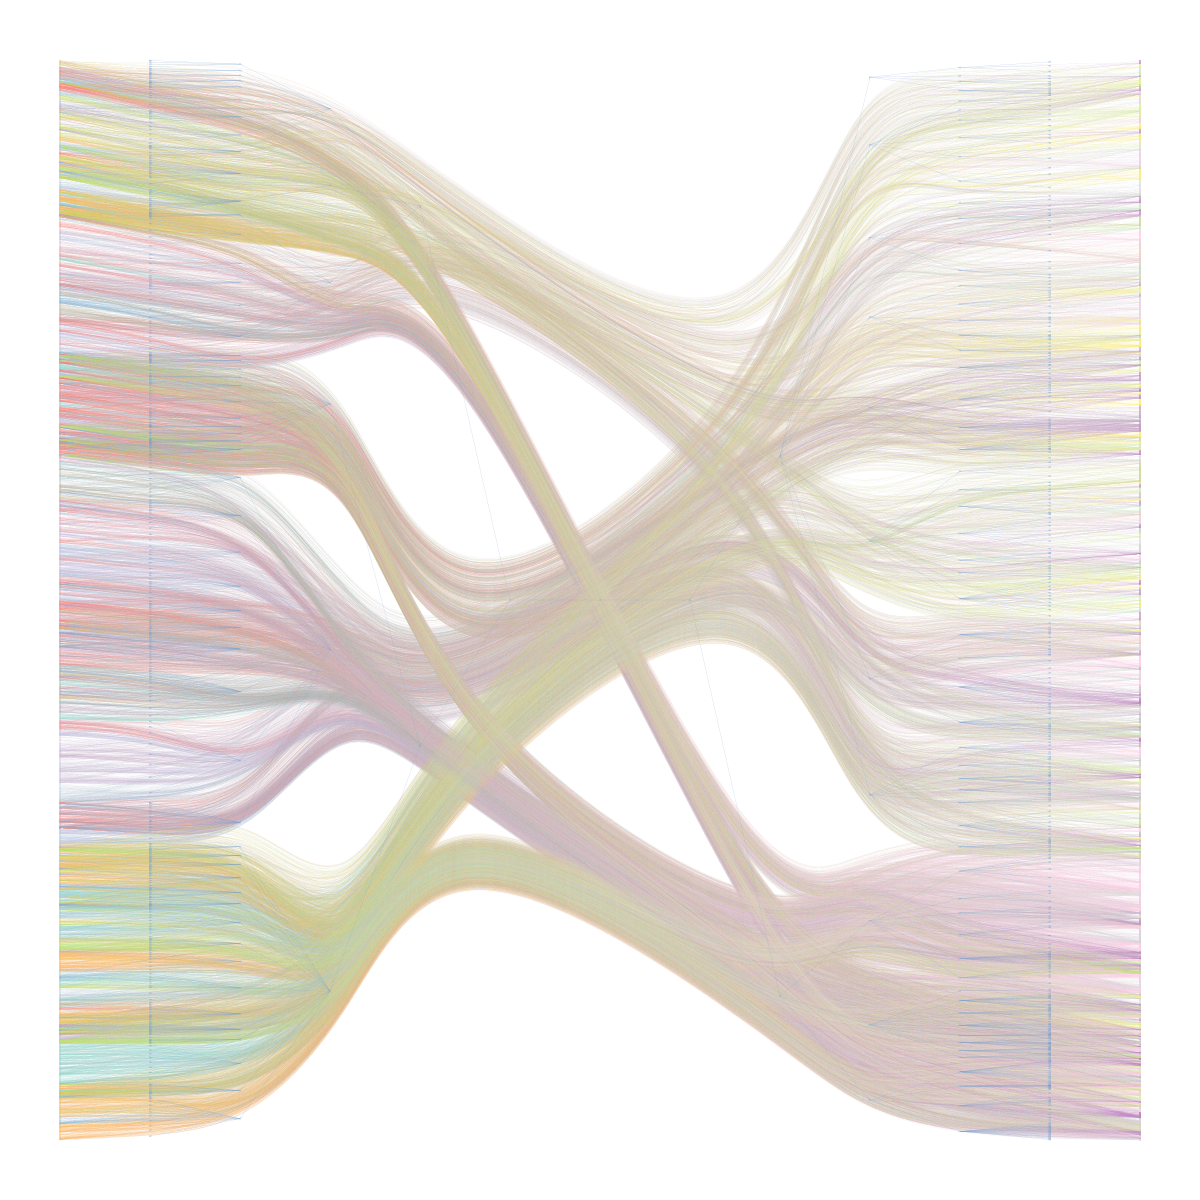

In [238]:
# We show the image of the bipartite network generated through th hSBM. 
print('                 Bipartite network of documents and words')
Image(filename = "hSBM_Topicmodel_04.12.png", width=600, height=600)


**Selecting relevant topics** <br>
The full list of topics generated at Level 1 appear in the dataframe below  

In [239]:
# Printing all rows in the dataframe of topics 
pd.set_option("display.max_rows", None, "display.max_columns", None)
topics

Topic      Topic_words  Probability_of_word_in_topic
0        0      information                      0.129238
1        0           health                      0.121458
2        0    communication                      0.093358
3        0          network                      0.087668
4        0              san                      0.045402
5        0        minnesota                      0.036925
6        0              van                      0.036345
7        0       evaluation                      0.021482
8        0        variation                      0.021017
9        0      minneapolis                      0.014166
10       1         analysis                      0.083767
11       1          student                      0.079832
12       1          process                      0.057623
13       1         approach                      0.052088
14       1           method                      0.050854
15       1        structure                      0.047552
16       1        scientist                      0.030446
17       1            focus                      0.029112
18       1         thinking                      0.025177
19       1          applied                      0.024610
20       2              one                      0.085910
21       2             many                      0.039139
22       2             much                      0.019716
23       2        according                      0.018976
24       2             like                      0.017177
25       2           become                      0.016922
26       2       considered                      0.015429
27       2          subject                      0.015352
28       2             took                      0.014867
29       2            point                      0.014523
30       3                –                      0.045171
31       3             time                      0.044816
32       3           became                      0.027293
33       3           family                      0.018998
34       3            wrote                      0.018604
35       3            known                      0.017647
36       3             well                      0.017392
37       3            early                      0.017361
38       3             part                      0.016936
39       3             view                      0.016898
40       4             1919                      0.030428
41       4             1920                      0.030428
42       4             1921                      0.025328
43       4             1912                      0.022777
44       4             1913                      0.022425
45       4             1915                      0.021282
46       4             1916                      0.019260
47       4             king                      0.015918
48       4             1902                      0.015478
49       4         commerce                      0.015038
50       5           member                      0.083111
51       5         national                      0.081484
52       5            board                      0.034424
53       5             free                      0.032492
54       5             june                      0.031856
55       5          january                      0.031246
56       5            april                      0.028907
57       5        committee                      0.026924
58       5         february                      0.026797
59       5            named                      0.023492
60       6            press                      0.117597
61       6             2006                      0.028340
62       6             2007                      0.027954
63       6             2004                      0.026683
64       6             2005                      0.026333
65       6             2011                      0.026296
66       6             2002                      0.023755
67       6             2012                      0.023405
68 

For each of the generated topics, we examine the 10 most probable words in order to select a subset of topics which we assess to be the most interesting to further examine. We draw on a heuristic approach which implies that we select topics that we assess to be semantically coherent and exclusive. Furthermore, we only select topics that we assess to be related to the content of the theoretical contributions of the researchers and we discard topics that appear to be related to academic prestige, timely relevans (topics consisting only of years e.g. Topic 6 and 4), and nationality (topics consisting of city names and words in non-English languages e.g. Topic 26 and 43). We select a subset of 21 topics which we assign appropriate descriptive names in the dictionary below.

In [4]:
#We create a dictionary with a number with the selected topic as key and value
topic_dict={'7':'Child/mother relations',
           '8':'Anthropology',
           '12':'State Administration',
           '14':'History and Society',
           '16':'Government Policy',
           '19':'Finance',
            '20':'Human Experience',
            '21':'World Order',
            '22':'Culture',
            '24':'Power relations',
            '25':'Effects and correlations',
            '27':'Philosophy',
            '34':'Religious Movements',
            '38':'Democratic Policy Making',
            '42':'Economics',
            '48':'Gender and Race',
            '49':'Sociology',
            '52':'Cognition',
            '55':'Government Systems',
            '56':'Market Mechanisms',
            '58':'Psychology'}

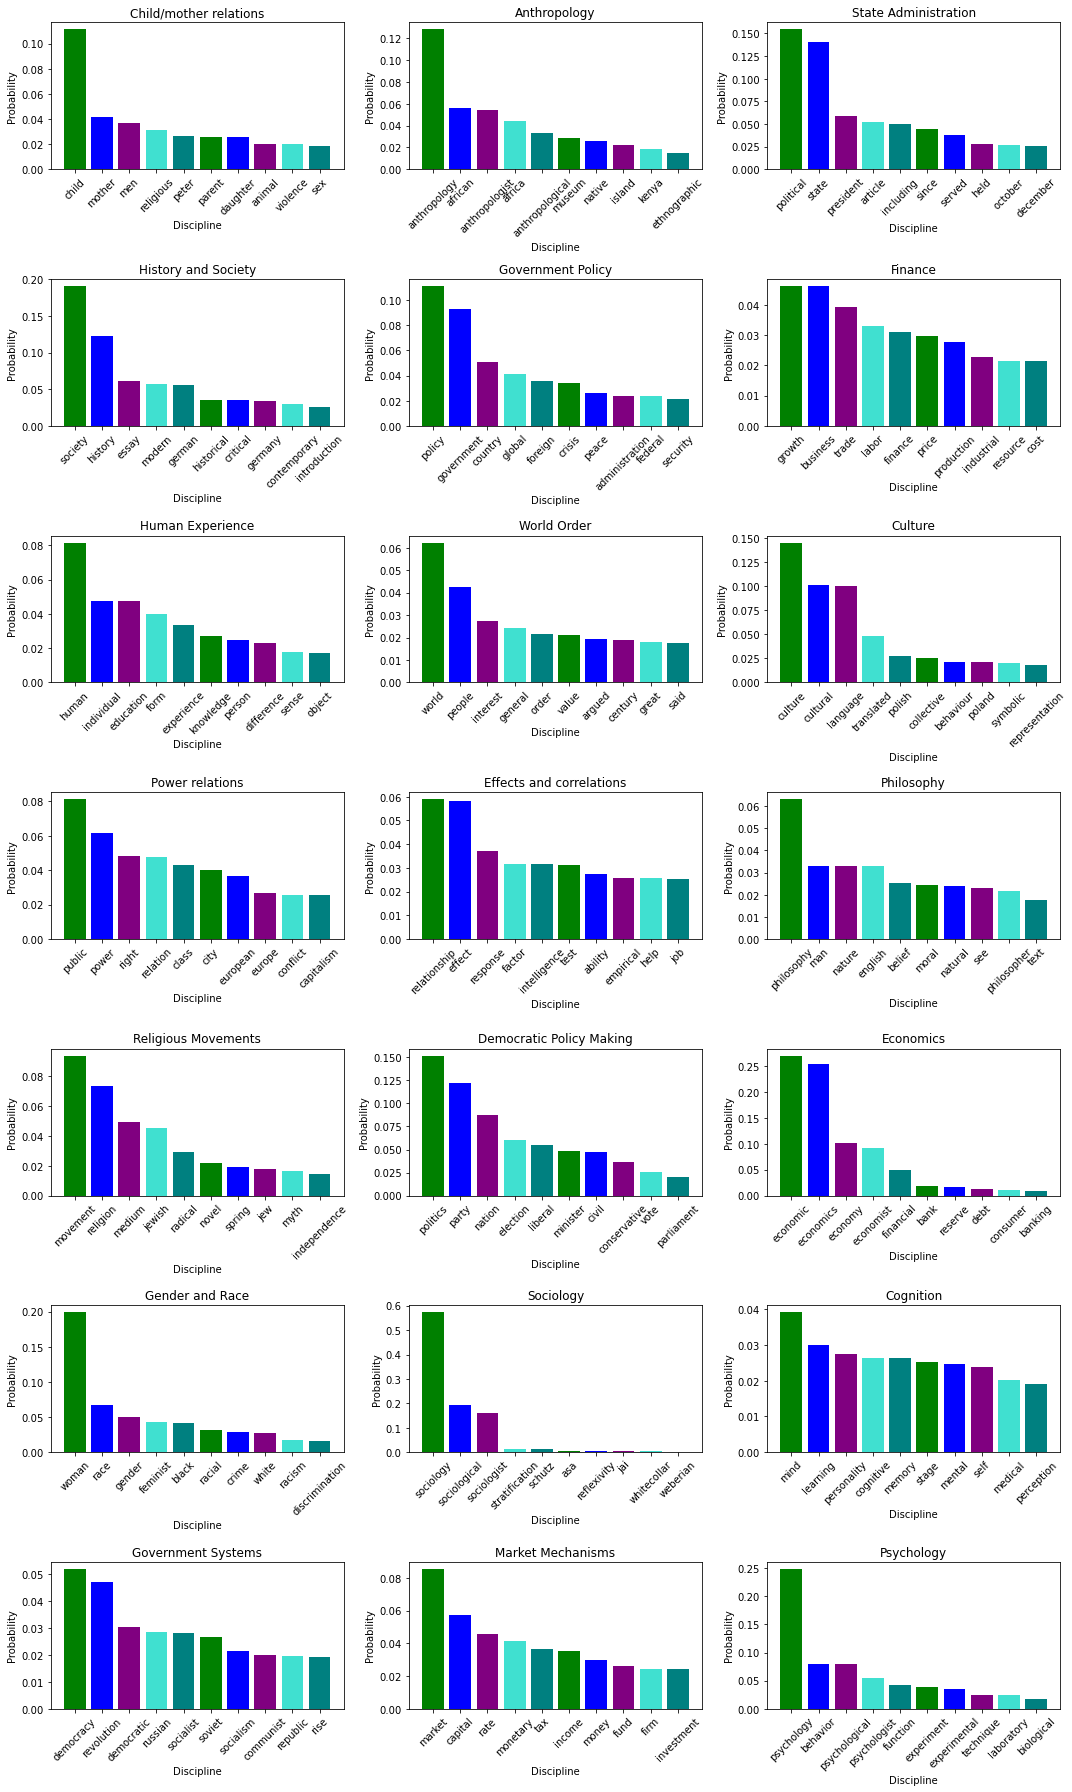

In [5]:
''' We create a bar plot of the most important words within each of the selected topics '''

# We define the colors
color= ['green','blue','purple','turquoise','teal']

# We make subplots 
fig, ax = plt.subplots(7, 3, figsize=(15, 25))

# We loop over each topic, topic_nr and index
for topic_nr,topic,i in zip(topic_dict.keys(),topic_dict.values(),range(len(topic_dict.values()))):
    
    # Based on the index of the topic we create the axis-variable defining the position of the plot
    if i<3:
        axis=ax[0,i]        
    if i>=3 and i<6:
        i = i-3
        axis=ax[1,i]
    if i>=6 and i<9:
        i = i-6
        axis=ax[2,i]
    if i>=9 and i<12:
        i=i-9
        axis=ax[3,i]        
    if i>=12 and i<15:
        i =i-12
        axis=ax[4,i]
    if i>=15 and i<18:
        i=i-15
        axis=ax[5,i]        
    if i>=18:
        i =i-18
        axis=ax[6,i]
    
    # We create a bar plot for each topic with a bar showing probability for each word in the topic
    axis.bar(list(topics[topics['Topic']==int(topic_nr)]['Topic_words']),
             list(topics[topics['Topic']==int(topic_nr)]['Probability_of_word_in_topic']),color=color)
    #We set title and labels
    axis.set_title(topic)
    axis.set_xlabel('Discipline')
    axis.set_ylabel('Probability')
    axis.tick_params(axis='x', labelrotation = 45)
    fig.tight_layout()
    
plt.savefig('topics_barplots.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

# Topics within disciplines and communities 

**Examining distribution of topics within disciplines** <br>
After having examined and selcted a subset of topics generated by the hSBM, we move on to find the distribution of each topic within the disciplines. By doing this, we want to find out whether the social scientists across different disciplines deal with the same topics or if their discipline bind them to certain topics. 

In [6]:
# We subset the dataframe of topic probabilities for each document to contain only the selected topics
HSBM_probs_topics=HSBM_probs[['name','discipline','community','text']+list(topic_dict.keys())]

# We rename the topics to the ascribed titles
HSBM_probs_topics=HSBM_probs_topics.rename(columns=topic_dict)

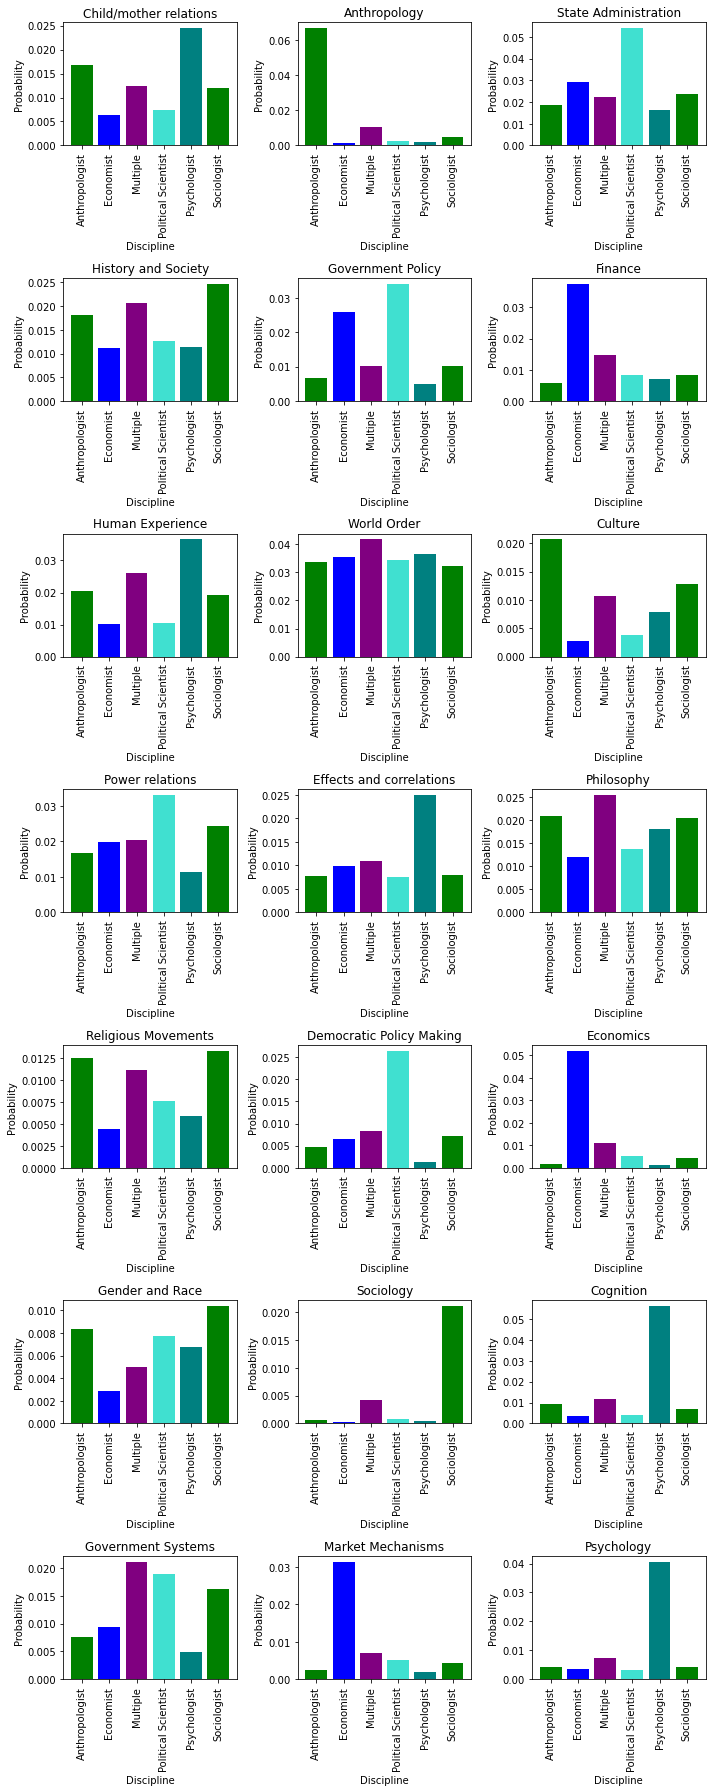

In [329]:
'''We create bar plots for each topic showing that show contributions from all disciplines'''

# We group all document by the disciplines, they belong to. 
HSBM_probs_discipline=HSBM_probs_topics.groupby('discipline',as_index=False).mean()

# We make subplots 
fig, ax = plt.subplots(7, 3, figsize=(10, 25))

# We loop over each topic 
for i,topic in enumerate(HSBM_probs_discipline.columns[1:]):
    if i<3:
        axis=ax[0,i]        
    if i>=3 and i<6:
        i = i-3
        axis=ax[1,i]
    if i>=6 and i<9:
        i = i-6
        axis=ax[2,i]
    if i>=9 and i<12:
        i=i-9
        axis=ax[3,i]        
    if i>=12 and i<15:
        i =i-12
        axis=ax[4,i]
    if i>=15 and i<18:
        i=i-15
        axis=ax[5,i]        
    if i>=18:
        i=i-18
        axis=ax[6,i]

    # We create a bar plot for each topic 
    axis.bar(HSBM_probs_discipline.discipline,HSBM_probs_discipline[topic],color=color)
    axis.set_title(topic)
    axis.set_xlabel('Discipline')
    axis.set_ylabel('Probability')
    axis.tick_params(axis='x', labelrotation = 90)
    fig.tight_layout()
    
plt.savefig('Disciplines_topics_barplots.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

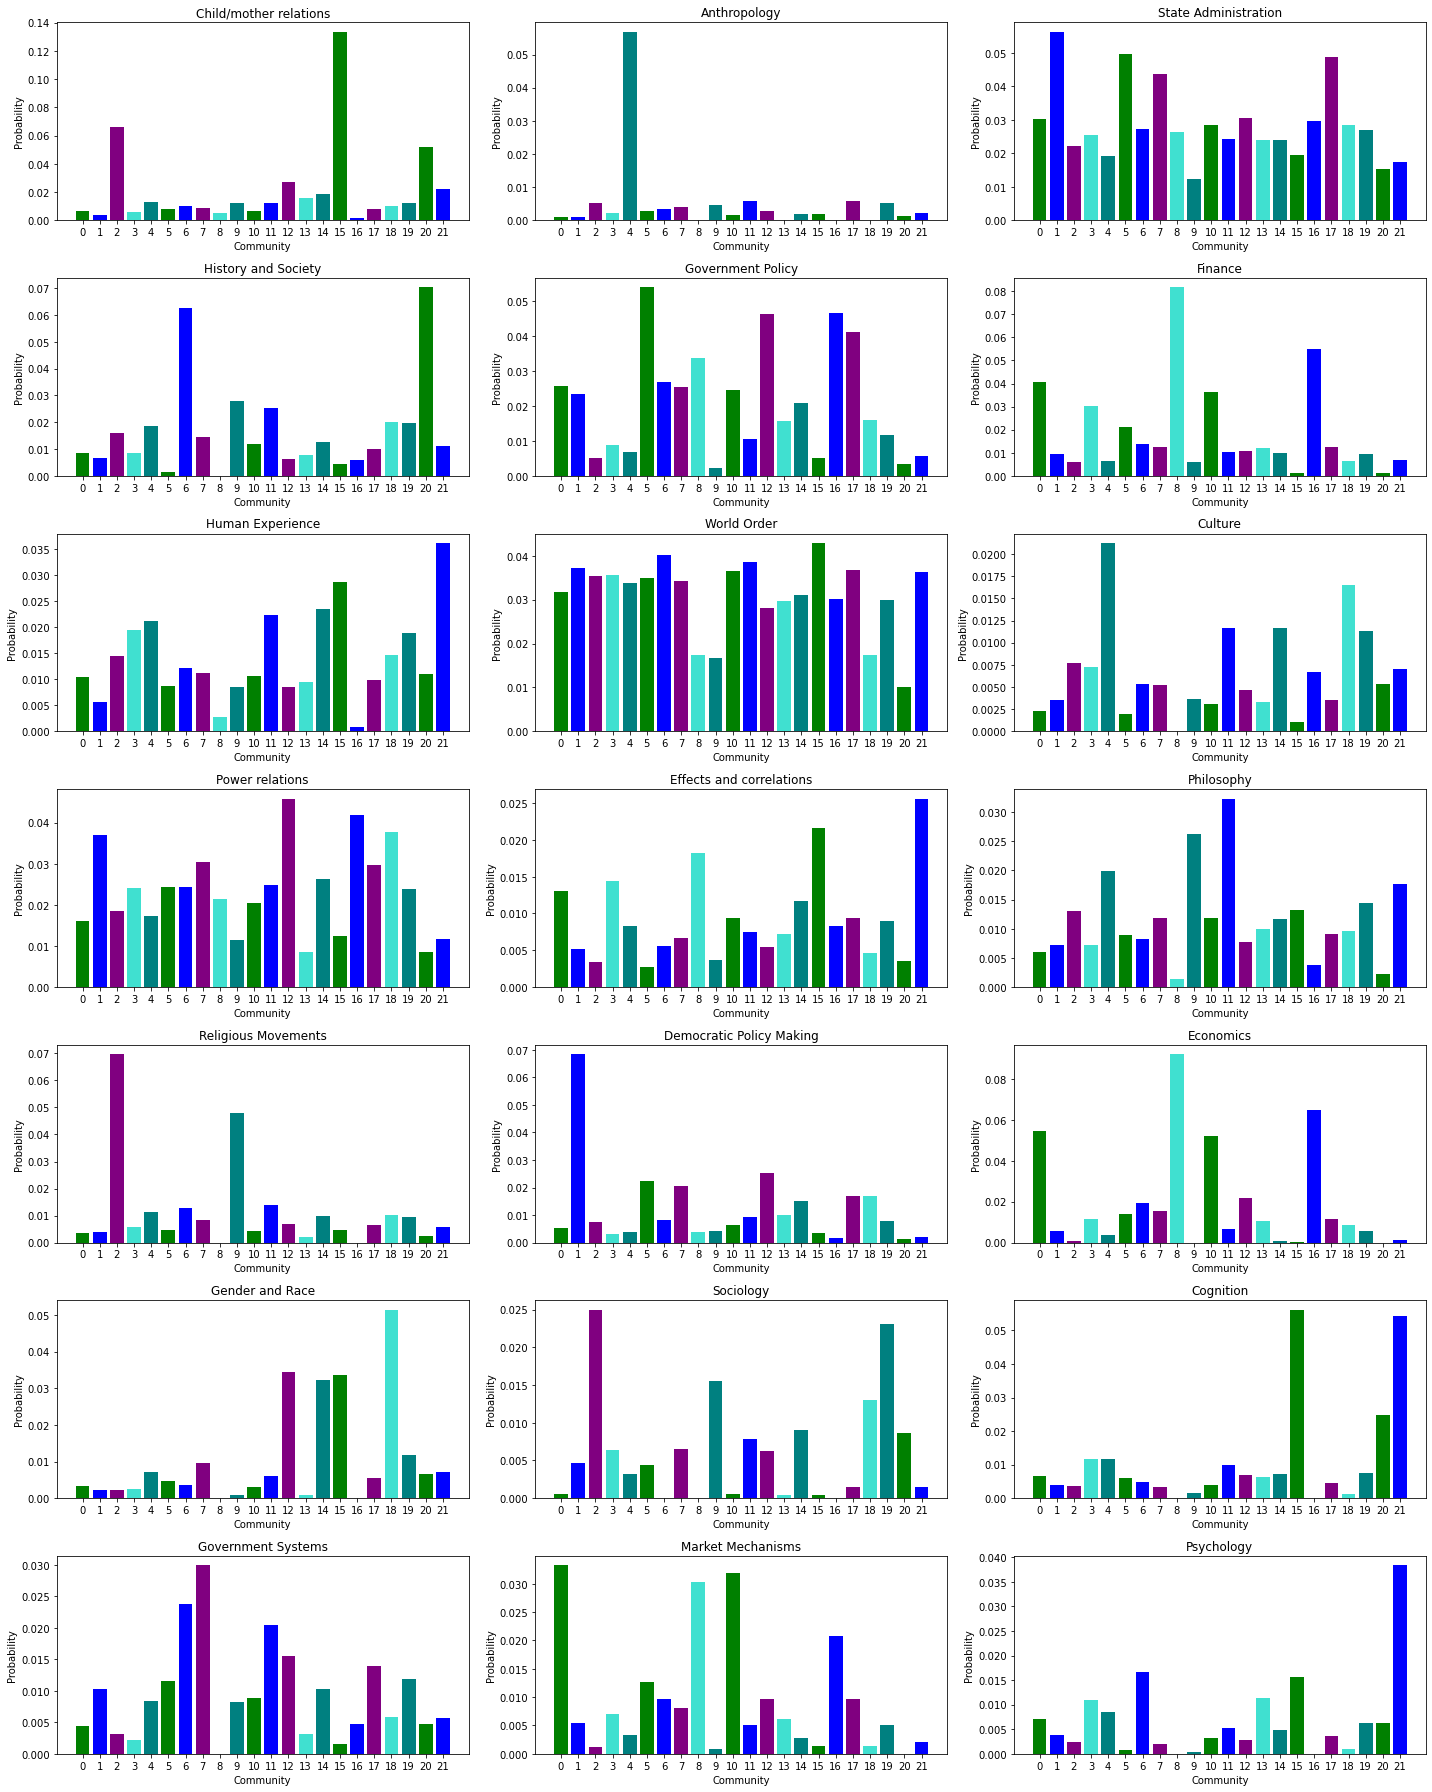

community
0      Daniel Kahneman - Daron Acemoglu - Greg Mankiw
1      David Butler - Robert McKenzie - Larry Bartels
2   David G. Bromley - Benjamin Zablocki - Jeffrey...
3   E. Wight Bakke - Neil W. Chamberlain - James G...
4    Franz Boas - Karl Polanyi - Bronisław Malinowski
5   Gloria Macapagal Arroyo - Randy David - Solita...
6   Hjalmar Schacht - Montagu Norman - Gustave Gil...
7   Immanuel Wallerstein - Paul Sweezy - Rosa Luxe...
8   James Brander - Tracy R. Lewis - Barbara J. Sp...
9   Jean Séguy - Jean-Paul Willaime - Ernst Troeltsch
10  John Maynard Keynes - Adam Smith - Milton Frie...
11              Karl Marx - Sigmund Freud - Max Weber
12  Marilyn Waring - Margunn Bjørnholt - Walden Bello
13      Michel Balinski - Steven Brams - Peyton Young
14                       Raewyn Connell - Ashis Nandy
15     Ray Blanchard - Richard Green - Kenneth Zucker
16  Richard Portes - Richard Baldwin - Joseph Fran...
17  Samuel P. Huntington - Kenneth Waltz - Henry K...
18              Sylvia Walby - Scott Lash - John Urry
19      Talcott Parsons - John Dewey - Erving Goffman
20  Volkmar Sigusch - Martin Dannecker - Gunter Sc...
21            Wilhelm Wundt - Jean Piaget - Carl Jung

In [322]:
  '''Showing distribution of topic for all Communities'''
# We group all document by the communities,we have identified. 
HSBM_probs_community=HSBM_probs_topics.groupby('community',as_index=False).mean()

# We make subplots 
fig, ax = plt.subplots(7, 3, figsize=(20,25))

# We loop over each topic 
for i,topic in enumerate(HSBM_probs_community.columns[1:]):
    if i<3:
        axis=ax[0,i]        
    if i>=3 and i<6:
        i = i-3
        axis=ax[1,i]
    if i>=6 and i<9:
        i = i-6
        axis=ax[2,i]
    if i>=9 and i<12:
        i=i-9
        axis=ax[3,i]        
    if i>=12 and i<15:
        i =i-12
        axis=ax[4,i]
    if i>=15 and i<18:
        i=i-15
        axis=ax[5,i]        
    if i>=18:
        i =i-18
        axis=ax[6,i]
        
    # We create a bar plot for each topic showing the contributions to the topic for each community 
    axis.bar(HSBM_probs_community.index,HSBM_probs_community[topic],color=color)
    axis.set_title(topic)
    axis.set_xlabel('Community')
    axis.set_ylabel('Probability')
    axis.set_xticks(range(22))
    fig.tight_layout()

plt.savefig('Communities_topics_barplots.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()
pd.DataFrame(HSBM_probs_community.community)

[**Comments on the above**]

# Bipartite networks with scientists and topics

Hostory and society is good for communities also mother/child. World order is interesting 

In [7]:
'''We initiate a bipartite network'''
# We create a dictionary from the dataframe with topic probablities 
HSBM_dict = HSBM_probs_topics.set_index('name').to_dict()

# We get all topics and persons - the node in the bipartite network
all_topics = list(HSBM_probs_topics.columns)[4:]
all_pers = HSBM_probs_topics['name']
# Make list of link sets
link_set = [(pers, topic) for pers in all_pers for topic in all_topics if HSBM_dict[topic][pers]!=0]

# We create a dictionary with edge weights 
link_weights = {(pers, topic):HSBM_dict[topic][pers] for pers in all_pers for topic in all_topics if HSBM_dict[topic][pers]!=0}

# We create network
G_bi=nx.Graph()
G_bi.add_nodes_from(all_pers,bipartite=0)
G_bi.add_nodes_from(all_topics,bipartite=1)
G_bi.add_edges_from(link_set)

# We Set weights 
nx.set_edge_attributes(G_bi, link_weights, name = "weight")

# We assign note attribute to the nodes based on whether they are nodes 'group'=0 or topics 'group'=1
node_attr = {n:d["bipartite"] for n,d in G_bi.nodes(data=True)}
nx.set_node_attributes(G_bi, node_attr, name="group")

In [9]:
# We define configurations for the network that create the nicest plot  
configurations= {'zoom': 1.1,
 'node_charge': -45,
 'node_gravity': 0.8487806050868936,
 'link_distance': 15,
 'scale_node_size_by_strength': True,
 'node_size': 13.474511789464156,
 'node_stroke_width': 0,
 'node_size_variation': 0.3218667971578566,
 'link_width_variation': 0.5}

# We initiate the network through netwulf 
network,config= nw.visualize(G_bi, plot_in_cell_below=False,config=configurations)

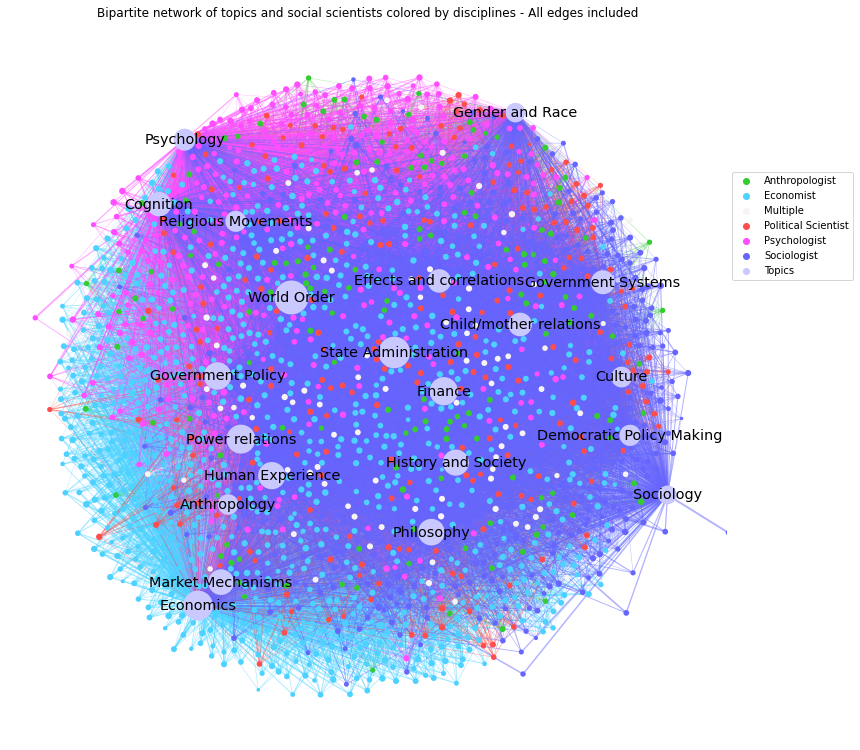

In [13]:
'''We assign colors to scientist-nodes based on discipline and visualize the network with all edges'''

# We define a color value map with a unique color for each discipline 
val_map = {'Sociologist':"#6666ff",
           'Anthropologist':"#33cc33",
           'Multiple':"#f9f4f4",
           'Political Scientist':"#ff4d4d",
           'Psychologist': '#ff4dff',
           'Economist': '#4dd2ff',
          'Topics':'#c9c9ff'}

# We loop over the scientist-nodes in the network that are not Topic-nodes to assign color 
for i in range(len(network['nodes'])-22):
    # We assign color based on the value map and the discipline for the node
    c=val_map[HSBM_probs_topics['discipline'][i]]
    network['nodes'][i].update({'color':c})
    
# We loop over topic nodes to assign color
for i in range(len(network['nodes'])-22,len(network['nodes'])):
    c = val_map['Topics']
    network['nodes'][i].update({'color':c})
    
# We loop over all links. 
for _link in range(len(network['links'])):
    edge_couple = network['links'][_link] # select edge couple
    scientist = edge_couple['source'] # source should always be the scientist.
    i=HSBM_probs_topics[HSBM_probs_topics['name']==scientist].index.values[0]
    
    # The source link is a scientist and link-color is assigned based on the color value map
    c=val_map[HSBM_probs_topics['discipline'][i]] 
    network['links'][_link].update({'color':c})
    
fig, ax = nw.draw_netwulf(network, figsize = 10)

# Adding labels to Topics 
for i in range(len(network['nodes'])-21,len(network['nodes'])):
    nw.tools.add_node_label(ax,network,network['nodes'][i]['id'],size='x-large')
    
# Add legends
for v in sorted(val_map.keys()):
    plt.scatter([],[],color=val_map[v], 
                label=v, 
                marker='o',
                linestyle="None")
# Place legend
plt.legend(bbox_to_anchor = (1,0.8))
plt.title('Bipartite network of topics and social scientists colored by disciplines - All edges included')
plt.savefig('Bipartite_dis_all.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

[**Comments on the network above**]

In [11]:
## We set new configurations and adjust the 'min_link_weight_percentile' to show the edges weights within the upper quartile 
configurations_weights= {'zoom': 1.1,
 'node_charge': -45,
 'node_gravity': 0.8487806050868936,
 'link_distance': 15,
 'scale_node_size_by_strength': True,
 'node_size': 13.474511789464156,
 'node_stroke_width': 0,
 'node_size_variation': 0.3218667971578566,
 'min_link_weight_percentile': 0.75}

#We initiate a new network with Netwulf 
network_high_weights,config=nw.visualize(G_bi, plot_in_cell_below=False,config=configurations_weights)

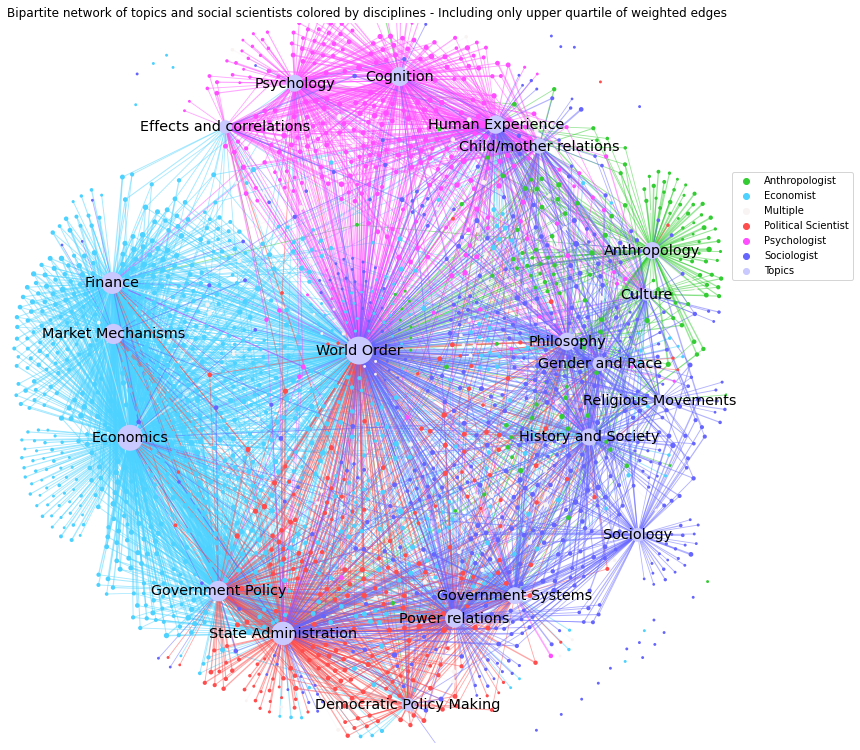

In [20]:
# We set colors for links, scientist nodes, and topic nodes
for i in range(len(network_high_weights['nodes'])-22):
    c=val_map[HSBM_probs_topics['discipline'][i]]
    network_high_weights['nodes'][i].update({'color':c})

for i in range(len(network_high_weights['nodes'])-22,len(network_high_weights['nodes'])):
    c = val_map['Topics']
    network_high_weights['nodes'][i].update({'color':c})
    
for _link in range(len(network_high_weights['links'])):
    edge_couple = network_high_weights['links'][_link] # select edge couple
    scientist = edge_couple['source'] # source should always be the scientist.
    i=HSBM_probs_topics[HSBM_probs_topics['name']==scientist].index.values[0]
    c=val_map[HSBM_probs_topics['discipline'][i]] 
    network_high_weights['links'][_link].update({'color':c})
    
fig, ax = nw.draw_netwulf(network_high_weights, figsize = 10)

# Adding labels to Topics 
for i in range(len(network_high_weights['nodes'])-22,len(network_high_weights['nodes'])):
    nw.tools.add_node_label(ax,network_high_weights,network_high_weights['nodes'][i]['id'],size='x-large')
    
# Add legends
for v in sorted(val_map.keys()):
    plt.scatter([],[],color=val_map[v], 
                label=v, 
                marker='o',
                linestyle="None")
# Place legend
plt.legend(bbox_to_anchor = (1,0.8))
plt.title('Bipartite network of topics and social scientists colored by disciplines - Including only upper quartile of weighted edges')
# plt.savefig('bipartite_dis_up.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

## Communities

In [16]:
''' Recolor nodes and links in bipartite network based on a HSBM_probs_topics-dataframe and colormap '''

def redefine_attr(network, df, _cmap = plt.cm.Spectral_r):
    import copy
    import matplotlib

    community = set(df['community']) # the attribute classes
    n_community = len(community) # how many are there? how many colors do we need?

    attr_scale_dict = {_cat:_num/(n_community-1) for _cat, _num in zip(community, range(n_community))}
    
    # Copy dict - deep copy as the values are nested in a list
    new_nw = copy.deepcopy(network)
    
    # Virker 
    for node_nr in range(len(new_nw['nodes'])):
        if node_nr <=len(new_nw['nodes'])-22:
    #             node = network['nodes'][node_nr]['id'] # node id 
            attr=df['community'][node_nr] # get the attribute class of the node
            num_attr = attr_scale_dict[attr] # get the numerical 
            _cmap_color = _cmap(num_attr)
            # overwrite node color based on new attr
            new_nw['nodes'][node_nr]['color'] = matplotlib.colors.rgb2hex(_cmap_color)
        if node_nr >=len(new_nw['nodes'])-21:
            new_nw['nodes'][node_nr]['color']='#c9c9ff'
            

    for _link in range(len(network['links'])):
        edge_couple = network['links'][_link] # select edge couple
        scientist = edge_couple['source'] # source should always be the scientist.
        attr =HSBM_dict['community'][scientist] # get the attribute class of the node
        num_attr = attr_scale_dict[attr] # get the numerical 
        _cmap_color = _cmap(num_attr)
        # overwrite node color based on new attr
        new_nw['links'][_link].update({'color':matplotlib.colors.rgb2hex(_cmap_color) })
#         new_nw['nodes'][node_nr]['color'] = matplotlib.colors.rgb2hex(_cmap_color)     
    
    return new_nw

In [17]:
# We load a dictionary containing sizes of each community. 
with open("../com_size_dict.json", "r", encoding = "utf-8") as f:
    com_size_dict = json.load(f)

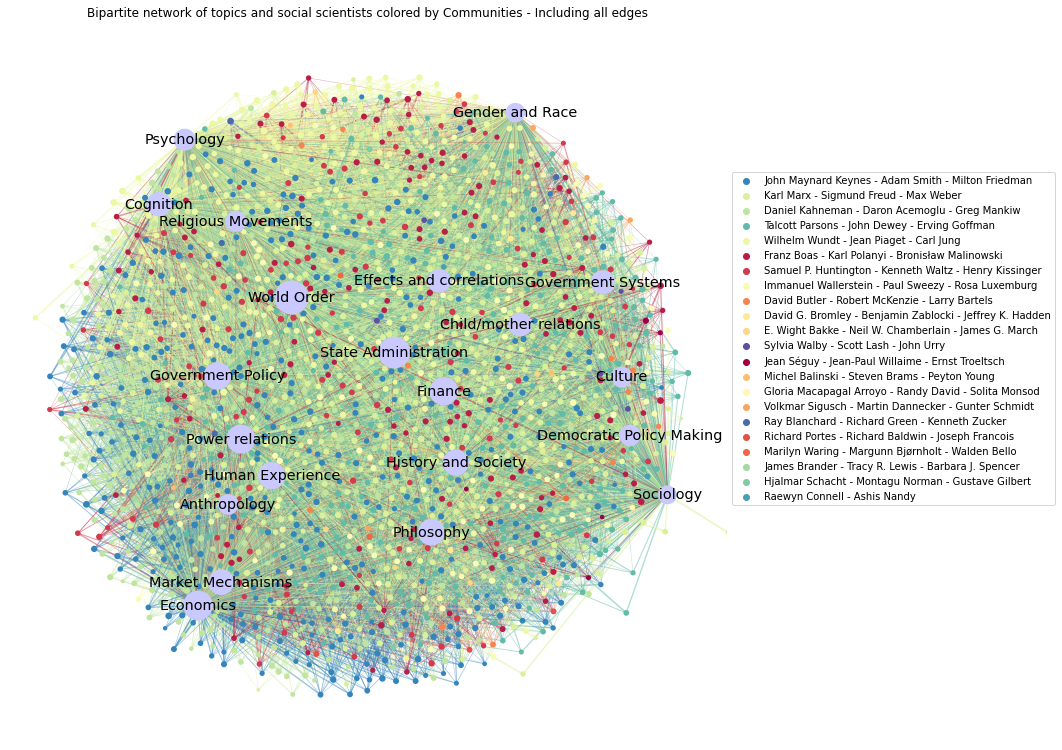

In [18]:
# We initialize a network for communities and draw it with Netwulf
network_communities=redefine_attr(network,HSBM_probs_topics)
fig, ax = nw.draw_netwulf(network_communities, figsize = 10)

# We add labels to Topics 
for i in range(len(network_communities['nodes'])-21,len(network_communities['nodes'])):
    nw.tools.add_node_label(ax,network_communities,network_communities['nodes'][i]['id'],size='x-large')

# We create a color map so nodes in each community gets a unique color
c_map={HSBM_probs_topics['community'][i]:network_communities['nodes'][i]['color']for i in range(len(HSBM_probs_topics['community']))}
c_map['Topics']='#c9c9ff'

# Add legends
for v in c_map.keys():
    plt.scatter([],[],color=c_map[v], 
                label=v, 
                marker='o',
                linestyle="None")
    
# Sort and Place legend
handles, labels = plt.gca().get_legend_handles_labels()
# Get the order of the legend - Based on community size 
order = [labels.index(_com) for _com in list(com_size_dict.keys())]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           bbox_to_anchor = (1,0.8))
    
# Place legend
plt.title('Bipartite network of topics and social scientists colored by Communities - Including all edges')
plt.savefig('bipartite_com_all.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

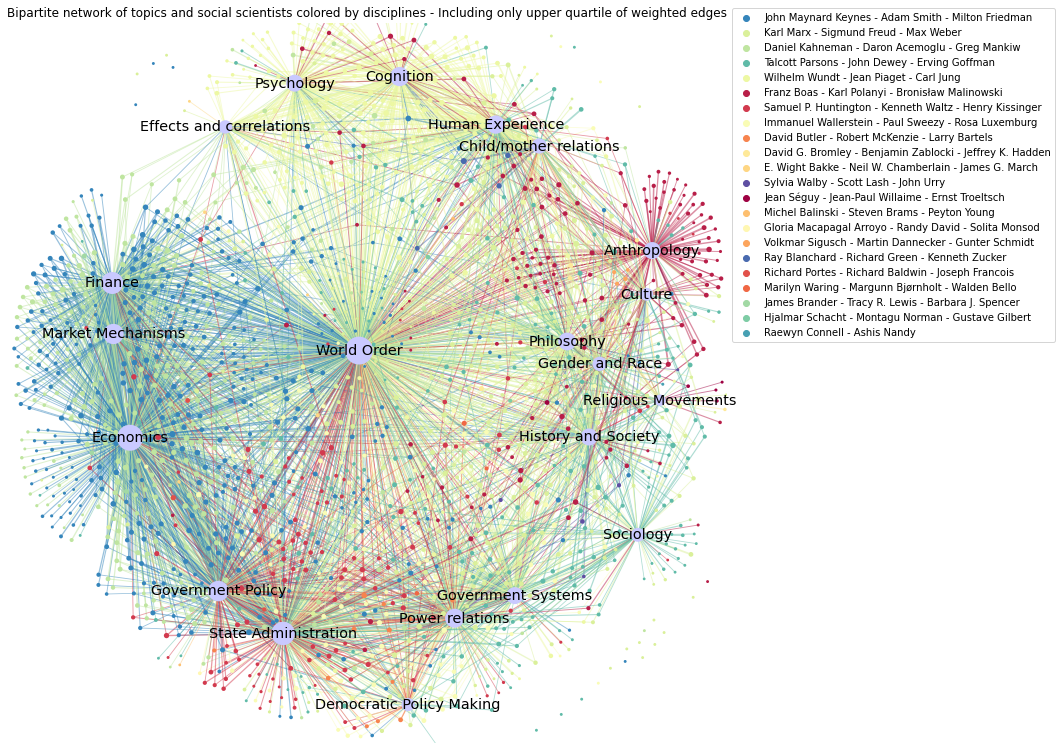

In [19]:
network_communuties_high_weights=redefine_attr(network_high_weights,HSBM_probs_topics)

fig, ax = nw.draw_netwulf(network_communuties_high_weights, figsize = 10)

# Adding labels to Topics 
for i in range(len(network_communuties_high_weights['nodes'])-21,len(network_communuties_high_weights['nodes'])):
    nw.tools.add_node_label(ax,network_communuties_high_weights,network_communuties_high_weights['nodes'][i]['id'],size='x-large')
    
import collections
c_map={HSBM_probs_topics['community'][i]:network_communuties_high_weights['nodes'][i]['color']for i in range(len(HSBM_probs_topics['community']))}
# c_map= collections.OrderedDict(sorted(c_map.items()))
c_map['Topics']='#c9c9ff'

# Add legends
for v in c_map.keys():
    plt.scatter([],[],color=c_map[v], 
                label=v, 
                marker='o',
                linestyle="None")
    
# Sort and Place legend
handles, labels = plt.gca().get_legend_handles_labels()
# Get the order of the legend - Based on community size 
order = [labels.index(_com) for _com in list(com_size_dict.keys())]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           bbox_to_anchor = (1,0.55))
    
plt.title('Bipartite network of topics and social scientists colored by disciplines - Including only upper quartile of weighted edges')
plt.savefig('bipartite_com_up.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()